# Data Parameters
(Basically, this will be deleted, as we keep iterating on this until we can get the next checkpoint)

Input

- Frames: 5 in 1 out
- Target: 1 station (LA N. Main St.)
- Channels: AirNow, Wind U/V, MASSDEN

Model
- Variation
```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 40, 40, 1)   │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
```
- Adam 1e-4 LR, 1e-2 WD

Result
- 19.95

General Notes
- adding channels

In [1]:
# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime
import sys
sys.path.append("../..")
#from libs.sequence import PWWBPyDataset

In [3]:
X_test_files =  ["HRRR_MASSDEN_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "AirNow_PM25_X_test.npy"]
X_train_files = ["HRRR_MASSDEN_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "AirNow_PM25_X_train.npy"]
X_valid_files = ["HRRR_MASSDEN_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "AirNow_PM25_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{path + file}" for file in X_train_files]
Y_training_files_paths = f"{path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
path = "final_input_data/two_years_with_hrrr/"
X_train = np.stack([np.load(f"{path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{path + Y_train_files}")
Y_test = np.load(f"{path + Y_test_files}")
Y_valid = np.load(f"{path + Y_valid_files}")

In [5]:
# 5 frames in, one frame and one station out
# next frame = 0
# LA station = 4
Y_train = Y_train[:, 0, [4]].copy()
Y_test = Y_test[:, 0, [4]].copy()
Y_valid = Y_valid[:, 0, [4]].copy()

# Model Definition

## Architecture

In [6]:
output_size = 1
input_shape = X_train.shape[1:] # (frames, height, width, channels)

print(
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape}\n"
    f"Output shape:  ({output_size})\n"
)

X_train shape: (12274, 5, 40, 40, 4)
Y_train shape: (12274, 1)

X_test shape:  (2631, 5, 40, 40, 4)
Y_test shape:  (2631, 1)

X_valid shape: (2630, 5, 40, 40, 4)
Y_valid shape: (2630, 1)

Input shape:   (5, 40, 40, 4)
Output shape:  (1)



In [7]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    ConvLSTM2D(
        filters=15, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

# applies layer to every temporal slice (first dimension)
# so for (5, 40, 40, 1), the layer is applied to each frame, a total of 5 times
#seq.add(TimeDistributed(Flatten()))
seq.add(Flatten())

#seq.add(Dropout(rate=0.1))

seq.add(Dense(output_size, activation='relu'))

seq.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.01)
)
seq.summary()

2025-07-06 17:52:35.579622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 17:52:35.587793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751849555.598322   62904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751849555.601791   62904 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-06 17:52:35.611993: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │        10,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,612 (310.98 KB)

 Trainable params: 79,612 (310.98 KB)

 Non-trainable params: 0 (0.00 B)

## Callbacks

In [8]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_file = 'experiment_output/basic_experiments/model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [9]:
history = seq.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks
)

Epoch 1/200


I0000 00:00:1751849561.498042   62988 service.cc:148] XLA service 0x5fa49ef56770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751849561.498062   62988 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-07-06 17:52:41.574658: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751849561.864518   62988 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-07-06 17:52:42.410988: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

  3/384 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 10.5156

I0000 00:00:1751849564.453910   62988 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 6.3703

2025-07-06 17:53:06.055940: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 17:53:06.179002: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,4,40,40]{3,2,1,0}, f32[15,4,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 6.3659

2025-07-06 17:53:10.533461: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,4,40,40]{3,2,1,0}, f32[15,4,3,3]{3,2,1,0}, f32[15]{0}, f32[6,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 17:53:10.576037: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

384/384 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 6.3615 - val_loss: 3.4325
Epoch 2/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 3.3175 - val_loss: 3.0810
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 3.1328 - val_loss: 2.7770
Epoch 4/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.9245 - val_loss: 2.8137
Epoch 5/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.8974 - val_loss: 2.6887
Epoch 6/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.7608 - val_loss: 2.7575
Epoch 7/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.5757 - val_loss: 2.5795
Epoch 8/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.5240 - val_loss: 2.7318
Epoch 9/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.4792 - val_loss: 2.5356
Epoch 10/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 2.3546 - val_loss: 2.6371
Epoch 11/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 2.2408 - val_loss: 2.5162
Epoch 12/200
384/384 ━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-07-06 18:18:45.292272: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,4,40,40]{3,2,1,0}, f32[15,4,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 18:18:45.333029: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

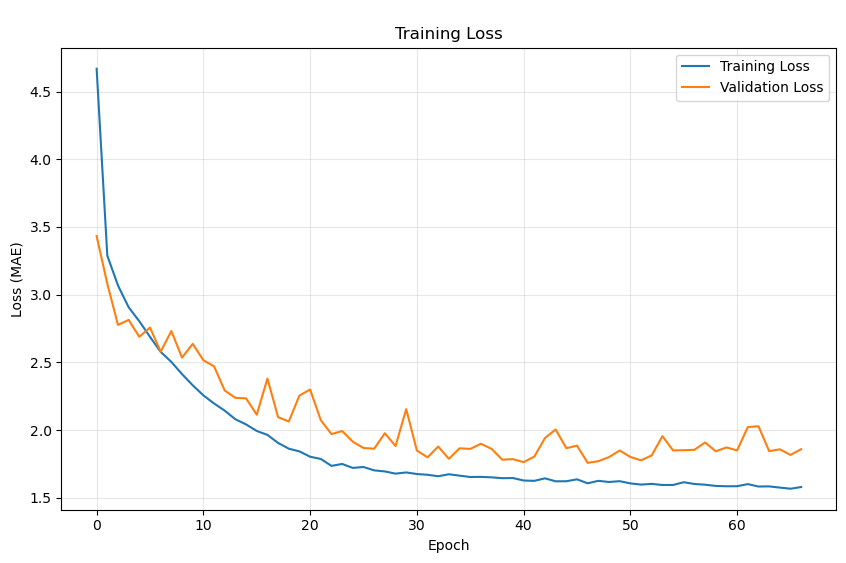

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = seq.predict(X_test, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
import sys
sys.path.append('../..')
from libs.plotting import *
import pandas as pd

results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338641,2.776573,2.312528
NRMSE,16.802139,19.953685,16.614529
MAE,1.462357,1.615195,1.171843
R2,0.867632,0.813500,0.870571


In [12]:
# clean up dead sensors
dead_sens = np.where(Y_test == 0)
print(len(dead_sens[0]))

cleaned_test = np.delete(Y_test, dead_sens)
cleaned_pred = np.delete(y_pred, dead_sens)
print(cleaned_test.shape)
print(cleaned_pred.shape)

results = [
    [
        rmse(cleaned_test[1:], cleaned_test[:-1]), 
        rmse(cleaned_pred, cleaned_test),
        rmse(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        nrmse(cleaned_test[1:], cleaned_test[:-1]),
        nrmse(cleaned_pred, cleaned_test),        
        nrmse(cleaned_pred[1:], cleaned_test[:-1]),

    ],
    [        
        mae(cleaned_test[1:], cleaned_test[:-1]),
        mae(cleaned_pred, cleaned_test),
        mae(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        r2_score(cleaned_test[:-1], cleaned_test[1:]),
        r2_score(cleaned_test, cleaned_pred),
        r2_score(cleaned_test[:-1], cleaned_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

15
(2615,)
(2615,)


,Baseline Error,Model Error,Model Error Shifted
RMSE,1.999741,2.557388,2.144187
NRMSE,14.283395,18.271252,15.315119
MAE,1.414116,1.553498,1.126850
R2,0.901122,0.838367,0.886322


In [13]:
sensor_names = ['Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel']
comprehensive_frame_analysis(y_pred, Y_test, sensor_names)

Comprehensive frame analysis requires multi-frame predictions


# Plots

## Snapshot plots

In [14]:
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

worst_week_cleaned = float('-inf')
worst_idx_cleaned = 0
for i in range(len(y_pred) - 168):
    err = nrmse(y_pred[i:i+168], Y_test[i:i+168])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i

    cleaned_err = nrmse(cleaned_pred[i:i+168], cleaned_test[i:i+168])
    if cleaned_err > worst_week_cleaned:
        worst_week_cleaned = cleaned_err
        worst_idx_cleaned = i

print(f"Best week {best_idx} to {best_idx+168} at {best_week:.2f}%")
print(f"Worst week {worst_idx} to {worst_idx+168} at {worst_week:.2f}%")
print(f"Worst week cleaned {worst_idx_cleaned} to {worst_idx_cleaned+168} at {worst_week_cleaned:.2f}%")

Best week 88 to 256 at 9.61%
Worst week 646 to 814 at 52.79%
Worst week cleaned 643 to 811 at 52.79%


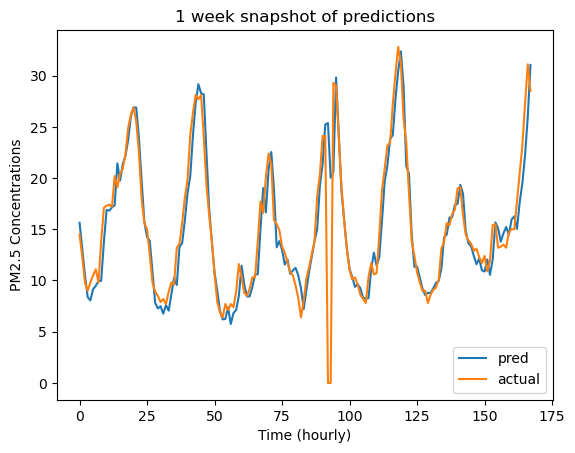

In [15]:
plt.plot(y_pred[1000:1168], label='pred')
plt.plot(Y_test[1000:1168], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")

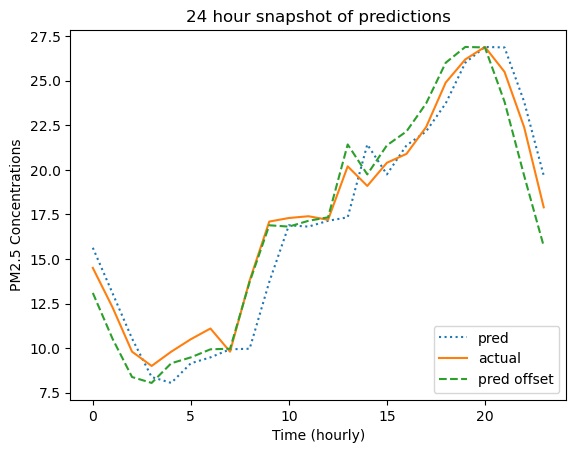

In [16]:
plt.plot(y_pred[1000:1024], linestyle=':', label='pred')
plt.plot(Y_test[1000:1024], label='actual')
plt.plot(y_pred[1001:1025], linestyle='--', label='pred offset')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("24 hour snapshot of predictions")
plt.legend(loc="lower right")

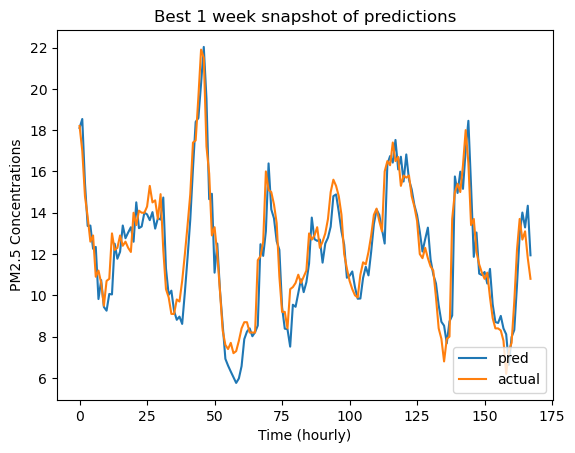

In [17]:
plt.plot(y_pred[best_idx:best_idx+168], label='pred')
plt.plot(Y_test[best_idx:best_idx+168], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("Best 1 week snapshot of predictions")
plt.legend(loc="lower right")

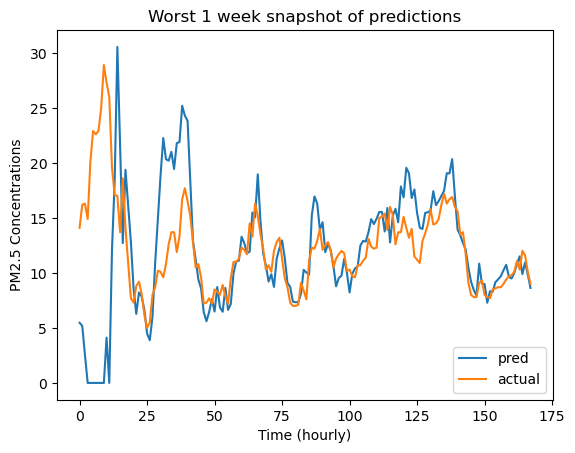

In [18]:
plt.plot(y_pred[worst_idx:worst_idx+168], label='pred')
plt.plot(Y_test[worst_idx:worst_idx+168], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("Worst 1 week snapshot of predictions")
plt.legend(loc="lower right")

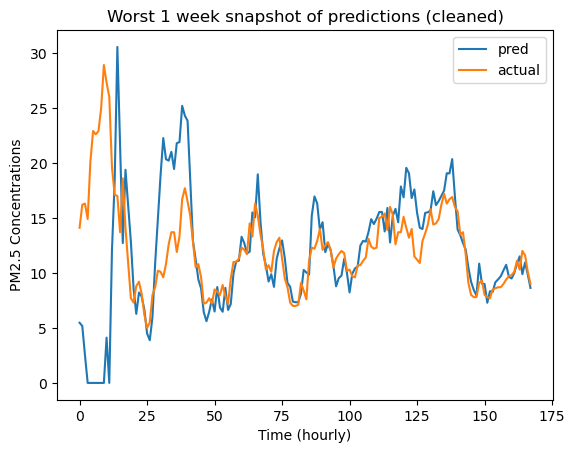

In [19]:
plt.plot(cleaned_pred[worst_idx_cleaned:worst_idx_cleaned+168], label='pred')
plt.plot(cleaned_test[worst_idx_cleaned:worst_idx_cleaned+168], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("Worst 1 week snapshot of predictions (cleaned)")
plt.legend(loc="upper right")

## Rolling avg plots

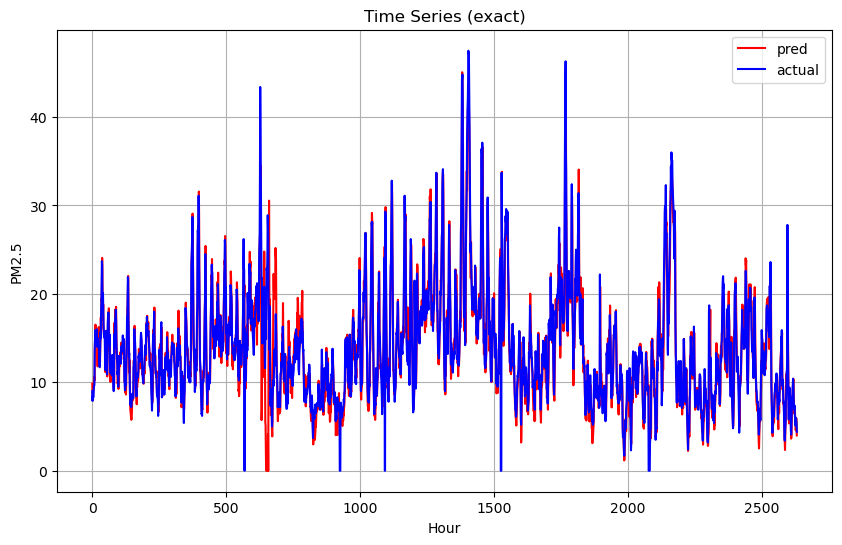

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred, label=f'pred', color='red')
plt.plot(Y_test, label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

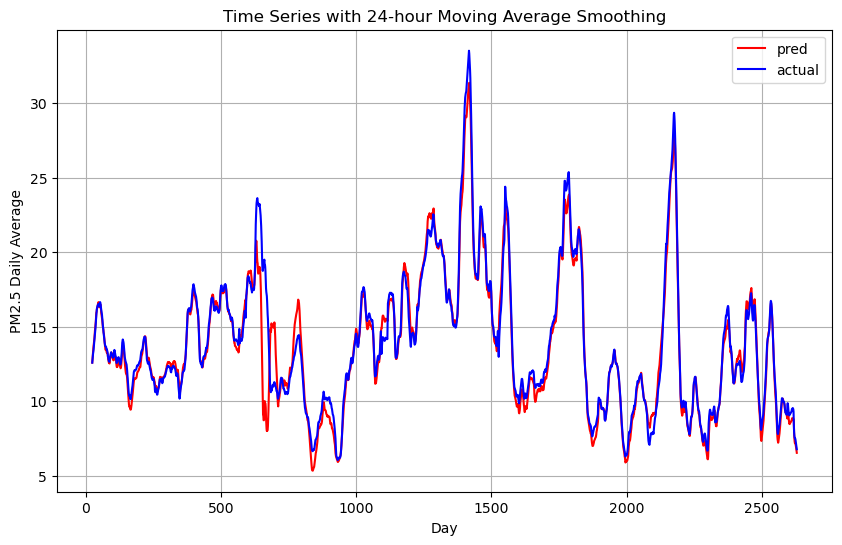

In [21]:
import pandas as pd

series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

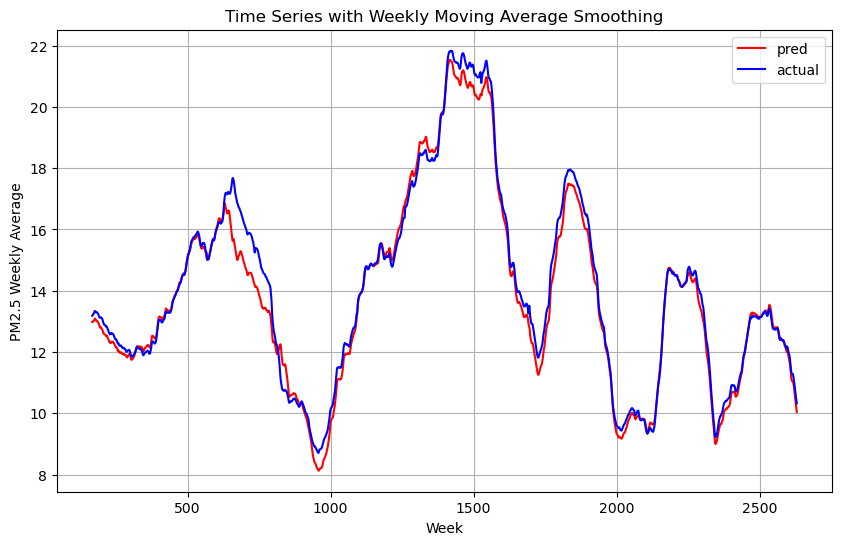

In [22]:
series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

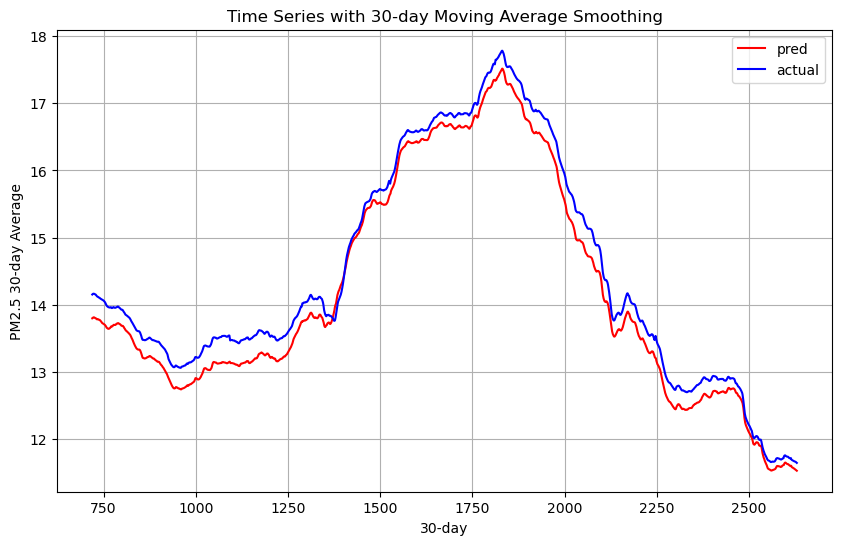

In [23]:
series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots

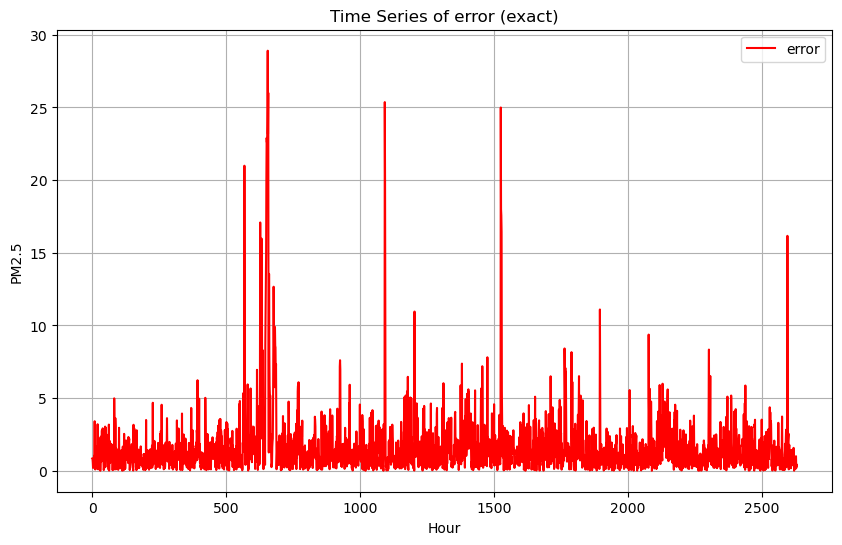

In [24]:
series = pd.Series(np.squeeze(np.abs(y_pred - Y_test)))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

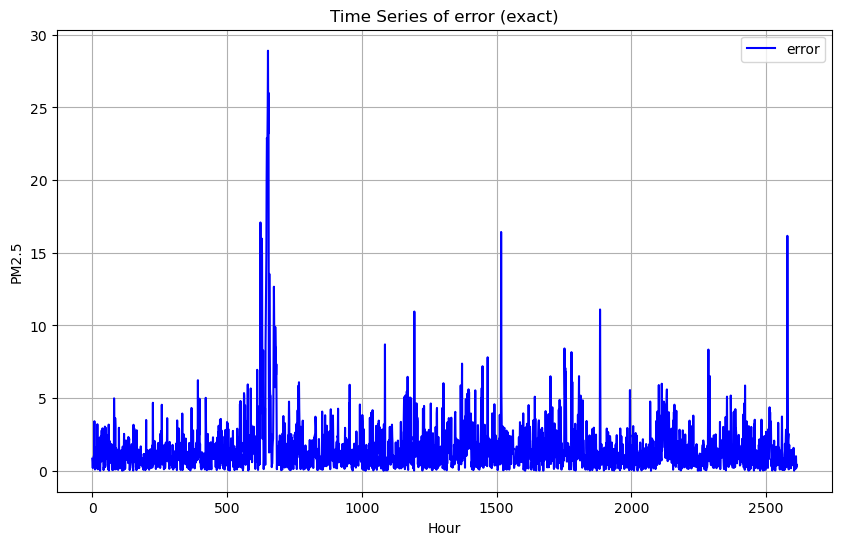

In [25]:
cleaned_series = pd.Series(np.squeeze(np.abs(cleaned_pred - cleaned_test)))
plt.figure(figsize=(10, 6))
plt.plot(cleaned_series, label=f'error', color='blue')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

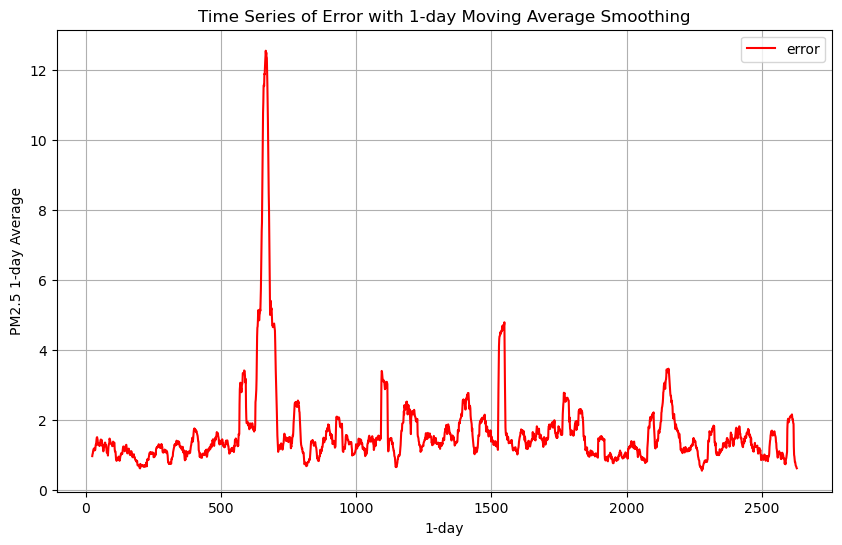

In [26]:
window_size = 24 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

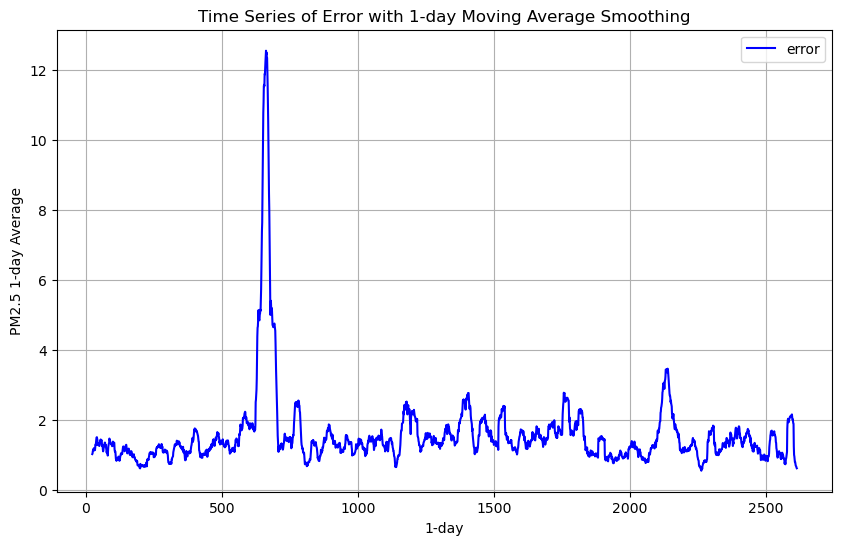

In [27]:
window_size = 24 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

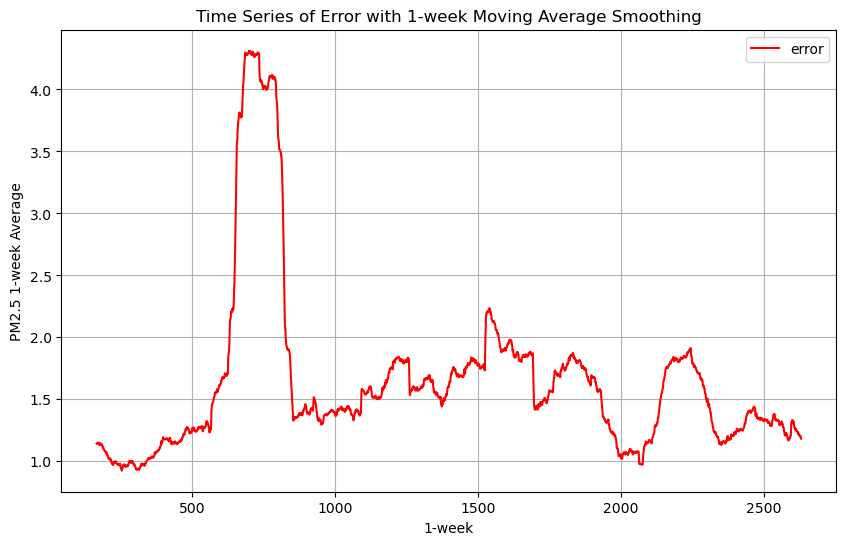

In [28]:
window_size = 168 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

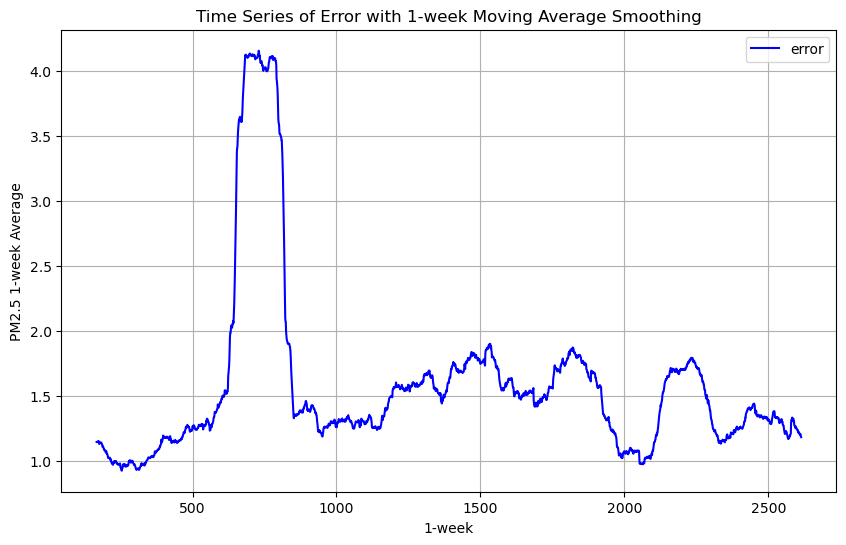

In [29]:
window_size = 168 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

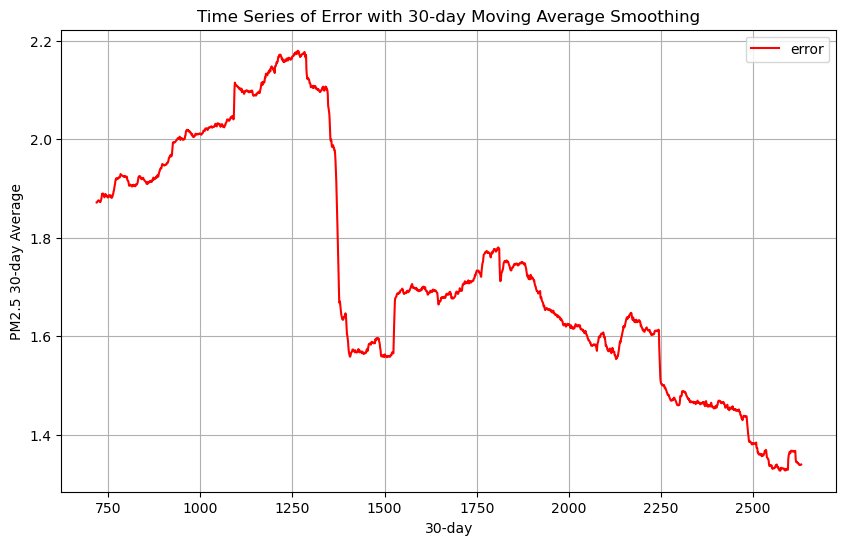

In [30]:
window_size = 720 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

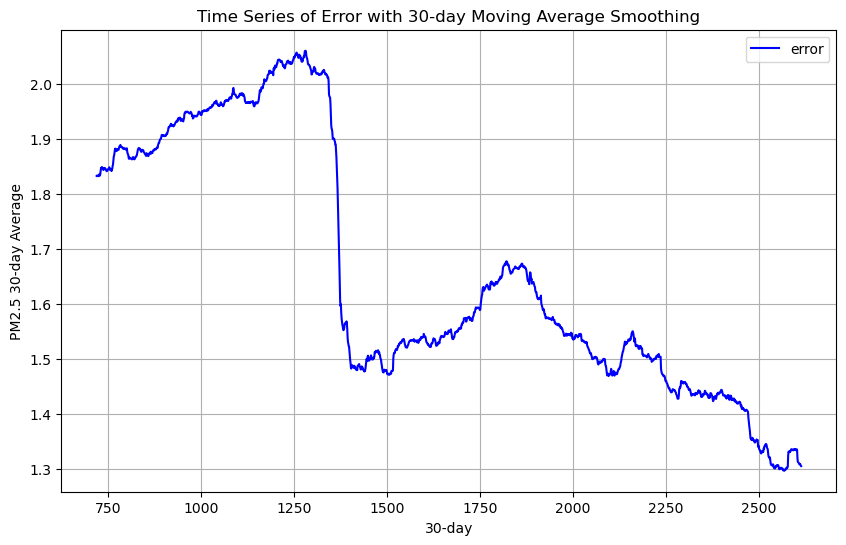

In [31]:
window_size = 720 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()